# X5 Retail Hero dataset

In [34]:
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_qini_curve
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [50]:
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from causalml.inference.meta import BaseXRegressor, BaseTClassifier, BaseSClassifier
from causalml.dataset import *
from causalml.metrics import *

plt.style.use('fivethirtyeight')

%matplotlib inline

In [36]:
df_clients = pd.read_csv('clients.csv', index_col='client_id')
df_train = pd.read_csv('uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('uplift_test.csv', index_col='client_id')

In [37]:
pd.to_datetime(df_clients['first_issue_date']).min()

Timestamp('2017-04-04 18:24:18')

In [38]:
from sklearn.model_selection import train_test_split

df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.to_datetime(df_features['first_issue_date']).min()) / pd.Timedelta('365d')

df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.to_datetime(df_features['first_redeem_date']).min()) / pd.Timedelta('365d')

df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']

df_features = df_features.join(pd.get_dummies(df_features['gender']))
df_features['first_redeem_time'] = df_features['first_redeem_time'].fillna(df_features['first_redeem_time'].mean())
df_features['issue_redeem_delay'] = df_features['issue_redeem_delay'].fillna(df_features['issue_redeem_delay'].mean())

df_features = df_features.drop(['first_issue_date', 'first_redeem_date', 'gender'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [39]:
df_features

,age,first_issue_time,first_redeem_time,issue_redeem_delay,F,M,U
client_id,,,,,,,
000012768d,45,0.336675,0.735365,0.398690,0,0,1
000036f903,72,0.015925,0.033211,0.017286,1,0,0
000048b7a6,68,1.698076,1.208236,0.476130,1,0,0
000073194a,60,0.133622,0.622100,0.488477,1,0,0
00007c7133,67,0.131265,1.724154,1.592889,0,0,1
...,...,...,...,...,...,...,...
fffece623e,67,1.106479,1.713402,0.606924,0,0,1
ffff3dfff8,56,1.577821,1.658431,0.080611,1,0,0
ffffaab9da,23,0.391817,0.661208,0.269391,1,0,0


In [40]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

# ATE

In [41]:
def get_mean_target(treatment_flg):
    return df_train.loc[indices_valid][df_train['treatment_flg']==treatment_flg]['target'].mean()

get_mean_target(1) - get_mean_target(0)

0.0325018461092893

# Double machine learning

In [42]:
from econml.dml import LinearDMLCateEstimator
from lightgbm import LGBMClassifier

est = LinearDMLCateEstimator(model_y=LGBMClassifier(max_depth=5), 
                             model_t=LGBMClassifier(max_depth=5),
                             discrete_treatment=True)
est.fit(y_train, treat_train, X_train)
uplift = est.const_marginal_effect(X_val)[:, 0]
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)

print(f"Uplift at 30: {score}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Uplift at 30: 0.038539054553511254


In [43]:
from econml.dml import NonParamDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

est = NonParamDMLCateEstimator(model_y=LGBMRegressor(),
                               model_t=LGBMRegressor(),
                               model_final=LGBMRegressor())
est.fit(y_train, treat_train, X_train)
uplift = est.effect(X_val.values)
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)

print(f"Uplift at 30: {score}")

Uplift at 30: 0.034836148121292654


# Meta Learners

## T-learner

In [44]:
#econml
from econml.metalearners import TLearner

est = TLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# T Learner
learner_t = BaseTClassifier(learner=LGBMClassifier())
learner_t.fit(X=X_train, treatment=treat_train, y=y_train)
cate_t = np.squeeze(learner_t.predict(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=cate_t, treatment=treat_val, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

#sklift
from sklift.models import TwoModels
tm = TwoModels(estimator_trmnt=LGBMClassifier(), estimator_ctrl=LGBMClassifier(), method='vanilla')
tm = tm.fit(X_train, y_train, treat_train)
uplift_tm = tm.predict(X_val.values)
score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.03794739518817292
causalml	| Uplift at 30: 0.05265201869140057
sklift		| Uplift at 30: 0.05265201869140057


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.0104'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

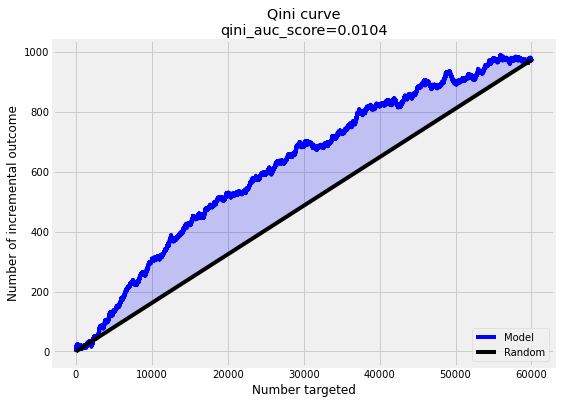

In [45]:
plot_qini_curve(y_true=y_val, uplift=cate_t, treatment=treat_val, negative_effect=True, perfect=False)

## S-learner

In [46]:
#econml
from econml.metalearners import SLearner

est = SLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")


#causalml
# S Learner
learner_s = BaseSClassifier(learner=LGBMClassifier())
learner_s.fit(X=X_train, treatment=treat_train, y=y_train)
cate_s = np.squeeze(learner_s.predict(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=cate_s, treatment=treat_val, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")


#sklift
from sklift.models import SoloModel

sm = SoloModel(LGBMClassifier())
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_val.values)
score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.037609394040101884
causalml	| Uplift at 30: 0.03968712549221021
sklift		| Uplift at 30: 0.03968712549221021


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.0090'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

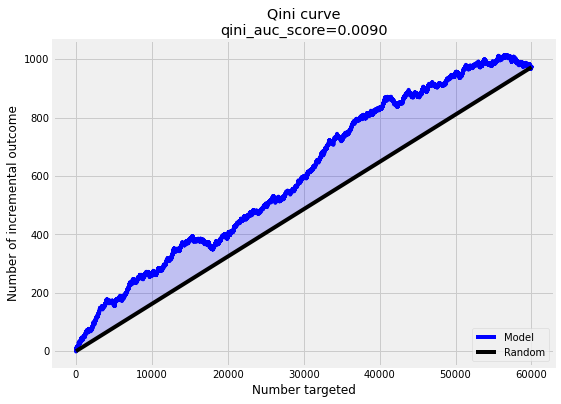

In [47]:
plot_qini_curve(y_true=y_val, uplift=cate_s, treatment=treat_val, negative_effect=True, perfect=False)

## X-Learner

In [52]:
#econml
from econml.metalearners import XLearner

est = XLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# X Learner
learner_x = BaseXRegressor(LGBMClassifier())
learner_x.fit(X=X_train, treatment=treat_train, y=y_train)
cate_x = np.squeeze(learner_x.predict(X_val.values))
score = uplift_at_k(y_true=y_val, uplift=cate_x, treatment=treat_val, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.037942989214175604
causalml	| Uplift at 30: 0.0378315810145321


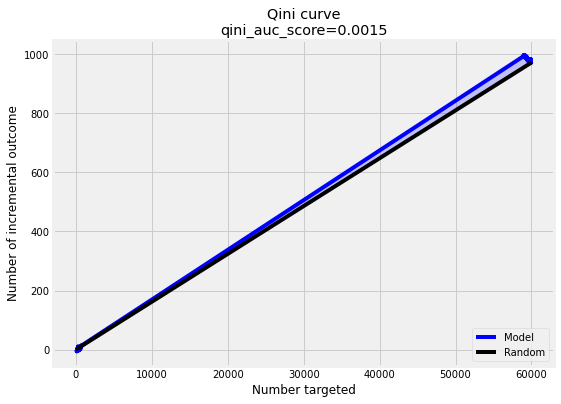

In [53]:
plot_qini_curve(y_true=y_val, uplift=cate_x, treatment=treat_val, perfect=False);